## Setup of system

In [1]:
import numpy as np
np.set_printoptions(precision=2) # 2 decimals when printing arrays
np.set_printoptions(suppress=True) # No scientific notation for small numbers
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.integrate import complex_ode
from numba import njit

from quantum_systems import ODQD, GeneralOrbitalSystem # library developed by Øyvind Schøyen and others, https://github.com/Schoyen/quantum-systems

In [2]:
l_0 = 10                # number of basis functions
grid_length = 10        # compute from x = -10 to x = 10 in 1D
num_grid_points = 2001
omega = 0.25            # strength of harmonic oscillator potential
n = 2                   # number of particles

# this sets up the harmonic oscillator basis functions and integrals between them
odho = ODQD(l_0, grid_length, num_grid_points, a = 0.25, alpha = 1, potential = ODQD.HOPotential(omega))

# this makes a spin up and spin down variant of the odho basis function and sets up the integrals between them
system = GeneralOrbitalSystem(n = n, basis_set=odho)
l = system.l
h = system.h
u = system.u

print(f"l = {system.l}")
print(f"grid shape = {system._basis_set.grid.shape}")
print(f"h shape = {system.h.shape}")
print(f"u shape = {system.u.shape}")
print(f"x shape = {system.position.shape}")
print(f"spf shape = {system.spf.shape}")

l = 20
grid shape = (2001,)
h shape = (20, 20)
u shape = (20, 20, 20, 20)
x shape = (1, 20, 20)
spf shape = (20, 2001)


In [3]:
@njit
def getP(C):
    l = C.shape[0]
    P = np.zeros((l, l), dtype="c16")
    
    for g in range(l):
        for d in range(l):
            for i in range(n):
                P[d, g] += np.conj(C[g, i]) * C[d, i]
    return P

@njit
def getF(C):
    l = C.shape[0]
    F = np.zeros((l, l), dtype="c16")
    P = getP(C)
    
    F += h
    for b in range(l):
        for a in range(l):
            for g in range(l):
                for d in range(l):
                    F[b, a] += P[d, g] * u[b, g, a, d]
    return F

@njit
def SCF(C, iters = 20):
    for i in range(iters):
        F = getF(C)
        vals, C = np.linalg.eigh(F)
    return C

In [73]:
C = np.eye(l, dtype="c16")

In [74]:
C = SCF(C, 20)

'GS 0 coefs: [-0.31  0.88 -0.    0.    0.11 -0.33  0.   -0.   -0.03  0.08 -0.    0.  0.   -0.   -0.    0.    0.   -0.   -0.    0.  ]'

'GS 1 coefs: [ 0.88  0.31 -0.   -0.   -0.33 -0.11  0.    0.    0.08  0.03 -0.   -0. -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.  ]'

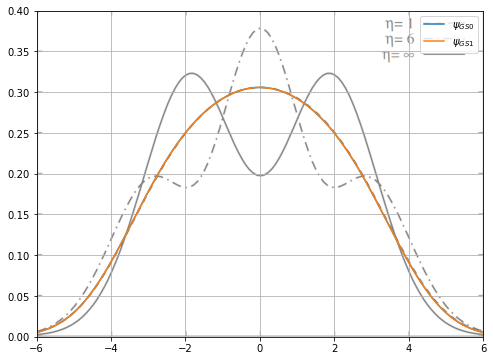

In [75]:
gs_0 = C[:, 0]
gs_1 = C[:, 1]
display(f"GS 0 coefs: {gs_0.real}".replace("\n", ""))
display(f"GS 1 coefs: {gs_1.real}".replace("\n", ""))

gs_vals_0 = np.zeros(num_grid_points, dtype = complex)
gs_vals_1 = np.zeros(num_grid_points, dtype = complex)
for i in range(l):
    gs_vals_0 += gs_0[i] * system.spf[i]
    gs_vals_1 += gs_1[i] * system.spf[i]

plt.figure(figsize=(8,6))
plt.plot(system.grid, np.abs(gs_vals_0)**2 / np.sum(np.abs(gs_vals_0)**2) * num_grid_points / 10, label=r"$\psi_{GS 0}$")
plt.plot(system.grid, np.abs(gs_vals_1)**2 / np.sum(np.abs(gs_vals_1)**2) * num_grid_points / 10, label=r"$\psi_{GS 1}$")

img=mpimg.imread('GS.PNG')
plt.imshow(img, extent=[-6, 6, 0, 0.4], aspect='auto', alpha = 0.5)

plt.xlim(-6, 6)
plt.grid()
plt.legend()
plt.show()

In [8]:
system.change_basis(C)
print(f"GS energy: {system.compute_reference_energy().real:.6f}")
print(f"Reference: {1.1795}")
print(f'"Exact"  : {0.8247}')
odho = ODQD(l_0, grid_length, num_grid_points, a = 0.25, alpha = 1, potential = ODQD.HOPotential(omega))
system = GeneralOrbitalSystem(n = n, basis_set=odho)

GS energy: 1.179579
Reference: 1.1795
"Exact"  : 0.8247


## TDHF

In [32]:
odho = ODQD(l_0, grid_length, num_grid_points, a = 0.25, alpha = 1, potential = ODQD.HOPotential(omega))
td_sys = GeneralOrbitalSystem(n = n, basis_set=odho)
td_sys.change_basis(C)
l_t = td_sys.l
h_t = td_sys.h
u_t = td_sys.u
pos_t = td_sys.position[0]
eps_0 = 1
omega_e = 8 * omega

In [33]:
@njit
def getPt(C):
    l = C.shape[0]
    P = np.zeros((l, l), dtype="c16")
    
    for g in range(l):
        for d in range(l):
            for i in range(n):
                P[d, g] += np.conj(C[g, i]) * C[d, i]
    return P

@njit
def laser(t):
    return eps_0 * np.sin(omega_e * t)

@njit
def getFt(t, C):
    l = C.shape[0]
    F = np.zeros((l, l), dtype="c16")
    P = getP(C)
    
    F += h_t
    F += pos_t * laser(t)
    for b in range(l):
        for a in range(l):
            for g in range(l):
                for d in range(l):
                    F[b, a] += P[d, g] * u_t[b, g, a, d]
    return F

@njit
def f(t, C):
    l = int(np.sqrt(C.shape[0]))
    C = C.reshape(l, l)
    F = getFt(t, C)
    Cdot = -1j * F @ C
    
    return Cdot.reshape(-1)

In [38]:
def tdhf():
    # Setup integration parameters
    y0 = np.eye(l_t).reshape(-1)

    t0 = 0
    t1 = 4 * 2 * np.pi / omega_e
    dt = 0.0001
    
    N = int((t1 - t0) / dt) + 2

    t = np.zeros(N)
    t[0] = t0
    y = np.zeros((N, y0.shape[0]), dtype="c16")
    y[0] = y0
    
    # Setting up integrator and performing integration
    r = complex_ode(f).set_integrator('vode')
    r.set_initial_value(y0, t0)

    i = 1
    while r.successful() and r.t < t1:
        y[i] = r.integrate(r.t + dt)
        t[i] = r.t
        i += 1

    if (i < N): #sometimes N will be too large due to numerical inaccuracy
        t = t[:i]
        y = y[:i]
        
    return t, y

In [39]:
t, y = tdhf()

In [40]:
overlap = np.zeros(y.shape[0])
C0 = np.eye(l_t)[:,0:2]

for i in range(y.shape[0]):
    Ci = y[i, :].reshape(l, l)
    Ci = np.conj(Ci[:,0:2]).T
    overlap[i] = np.abs(np.linalg.det(Ci @ C0))**2

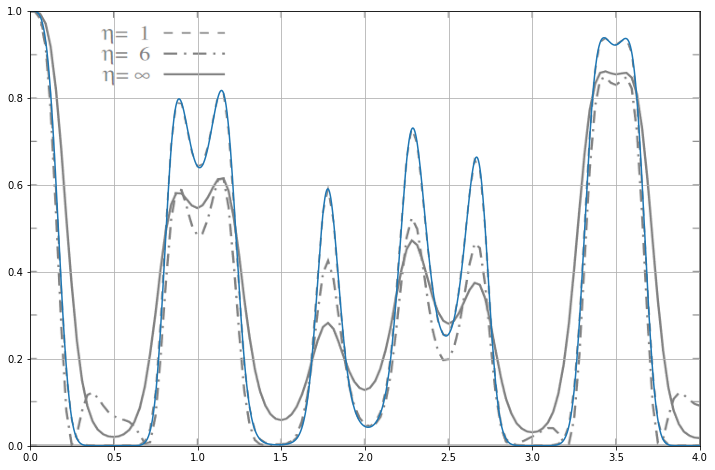

In [41]:
plt.figure(figsize=(12, 8))

unit = 2 * np.pi / omega_e
plt.plot(t / unit, overlap)

img=mpimg.imread('TD1.PNG')
plt.imshow(img, extent=[0, 4, 0, 1], aspect='auto', alpha = 0.5)

plt.grid()
plt.show()